# Conditional Density Estimator (using torch.distributions)
Using Gaussian mixture models and neural networks; April 20, 2020

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import mixture

import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.distributions as D

import sys
sys.path.append('../modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

1.5.1


To ensure torch.distributions.MixtureSameFamily is defined, use the [latest version](https://pytorch.org/docs/versions.html) of PyTorch.

## Data

The wrong way to do it. But I don't really know a better way. In the right way, the x-values should be sampled instead of y-values, and the distribution of x-values should look uniform, rather than normal.

In [3]:
def get_xs_and_ys():
    ys = np.random.uniform(low=-3.2, high=1.25, size=50000)
    ys = np.array(sorted(ys))
    xs = 3 * ys ** 2 + ys ** 3
    ys += np.random.normal(scale=0.2, size=len(ys))
    return xs, ys

In [4]:
xs, ys = get_xs_and_ys()

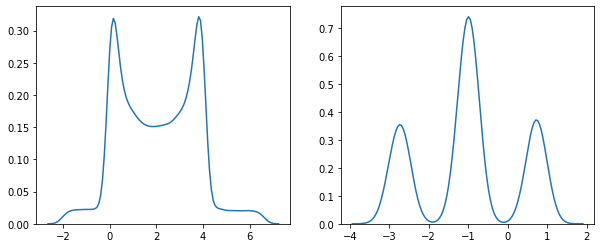

In [5]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
sns.kdeplot(xs, ax=ax)
ax = fig.add_subplot(122)
sns.kdeplot(ys[np.logical_and(xs > 1.8, xs < 2.2)], ax=ax)
plt.show()

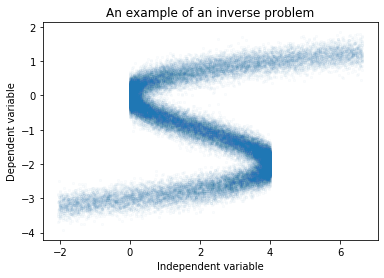

In [6]:
plt.scatter(xs, ys, s=5, alpha=0.02)
plt.title('An example of an inverse problem')
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [7]:
xs, ys = xs.reshape(-1, 1), ys.reshape(-1, 1)

In [8]:
def train_test_split(xs, ys, train_prop):
    train_num = int(train_prop * len(xs))
    idxs = np.arange(len(xs))
    np.random.shuffle(idxs)
    train_idxs, valid_idxs = sorted(idxs[:train_num]), sorted(idxs[train_num:])
    return (xs[train_idxs], ys[train_idxs]), (xs[valid_idxs], ys[valid_idxs])

In [9]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(xs, ys, 0.8)

In [10]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((40000, 1), (40000, 1), (10000, 1), (10000, 1))

The following weighted sampler make sure that less frequent examples are presented with equal chance compared to more frequent examples.

In [11]:
gmm = mixture.GaussianMixture(n_components=30, covariance_type='full')
gmm = gmm.fit(x_train.reshape(-1, 1))

In [12]:
densities = np.exp(gmm.score_samples(x_train.reshape(-1, 1)))

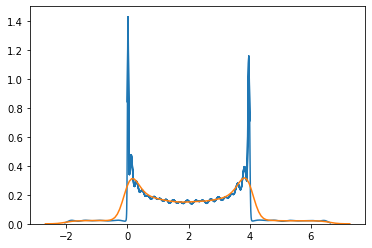

In [13]:
plt.plot(x_train.flatten(), densities)
sns.kdeplot(x_train.flatten())
plt.show()

In [14]:
sampler = WeightedRandomSampler(1 / densities, num_samples=len(densities))

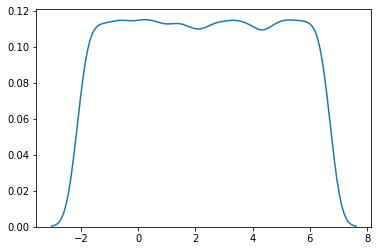

In [15]:
sns.kdeplot(x_train.flatten()[list(sampler)])
plt.show()

In [16]:
train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_ds = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
train_dl = DataLoader(train_ds, batch_size=64, sampler=sampler)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

## Model

Mixture models represent a distribution in terms of a linear combination of adaptive kernel functions.

**Mixture model for CDE.** The conditional density of target $t$ given input $x$:

$$p(\vec{t}|\vec{x})=\sum_{j=1}^M \alpha_j(\vec{x}) \phi_j(\vec{t}|\vec{x})$$

where $M$ is the number of components, $\alpha_j$'s are mixing coefficients, and $\phi_j$'s are kernel functions.

**Kernel function.** For this notebook, we restrict attention to kernel functions which are Gaussians of the form:

$$\phi_j(t|x)=\frac{1}{(2\pi)^{c/2}\sigma_j^c(\vec{x})} \exp \left\{ - \frac{\| \vec{t} - \vec{\mu}_j(\vec{x}) \| ^2}{2 \sigma_j^2(\vec{x})} \right\}$$

where:
- $c$ is the dimensionality of $\vec{t}$.
- $\sigma_j(\vec{x})$ is the common standard deviation of all dimensions of the output vectors for the $j$th kernel function given an input vector $\vec{x}$.
- $\vec{\mu}_j(\vec{x})$ is the mean of the output vectors for the $j$ kernel function given an input vector of $\vec{x}$.

The simplified Gaussian kernel function stated above can be extended to use full covariance matricess, but this is not necessary because the simplified version can approximate any given desnity function to arbitary accuracy, provided the mixing coefficients and the Gaussian parameters (mean and covariances) are correctly chosen. (McLachlan and Basford, 1988). 

$$
\phi_j(t|x)=\frac{1}{(2\pi)^{c/2} \det \left(\Sigma_j(\vec{x})\right)^{1/2}} \exp 
\left\{
-\frac{1}{2}
\left(\vec{t} - \vec{\mu}_j(\vec{x})\right) 
\Sigma^{-1} 
\left(\vec{t} - \vec{\mu}_j(\vec{x})\right)^T 
\right\}
$$

where:
- $\Sigma_j(\vec{x})$ is the covariance matrix of the $j$th kernel function given an input vector $\vec{x}$.
- $\Sigma_j(\vec{x})^{-1}$ is the inverse of the covariance matrix. 
- $\det \left(\Sigma_j(\vec{x})\right)$ is the determinant of the covariance matrix. 
- When all dimensions of the output vector $\vec{t}$ are independent and have the same variance, the covariance matrix reduces to a diagonal matrix of the form `shared_variance * np.eye(number_of_dimensions_of_t)`.
    - The determinant of the covariance matrix reduces to `shared_variance ** number_of_dimensions_of_t`.
    - The inverse of the covariance matrice reduces a `1 / shared_variance * np.eye(number_of_dimensions_of_t)`, which simply scales any vector that get multiplied with it by 1 / shared_variance.
    - These reductions help us understand how the simplified Gaussian kernel function obtained earlier was derived.

In [19]:
class CDEstimator(nn.Module):
    
    """Conditional density estimator using neural networks."""
    
    def __init__(self, input_dim, output_dim, num_comps, num_hidden):
        
        super().__init__()
        
        self.num_comps = num_comps
        self.output_dim = output_dim
        
        self.get_mixing_coeffs = nn.Sequential(
            
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
            nn.Softmax(dim=1)
        
        )
        
        self.get_means = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps * output_dim),
            
        )
        
        self.get_logvars = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
        
        )
        
    def forward(self, x):
        
        mixing_coeffs = self.get_mixing_coeffs(x)
        means = self.get_means(x).view((-1, self.num_comps, self.output_dim))
        variances = torch.exp(self.get_logvars(x))
        
        return {
            'mixing_coeffs' : mixing_coeffs,
            'means' : means,
            'variances' : variances
        }

In [20]:
def nll_loss(params, t):
    
    # in this function, calling view on tensors are not supposed to change their shapes;
    # it just serves the purpose of making code easier to read and understand
    
    k = params['mixing_coeffs'].size(1)
    bs = params['mixing_coeffs'].size(0)  # may reduce at the end of an epoch, so don't set it to a fix number here
    dimension = 1  # we are predicting one variable here, so 1 dimensional gaussians are adequate
        
    mix = D.Categorical(params['mixing_coeffs'].view(bs, k))
    comp = D.Independent(
        D.Normal(
            params['means'].view(bs, k, dimension), 
            params['variances'].view(bs, k, dimension)
        ),
        reinterpreted_batch_ndims=1  # interpret the 1-st dimension as the "component" dimension
    )
    
    gmm = D.MixtureSameFamily(mix, comp)
    
    nll_loss = - torch.sum(gmm.log_prob(t.view(bs, dimension)))
    
    return nll_loss

In [21]:
def get_model(num_components):
    nn = CDEstimator(1, 1, num_components, 200)  
    return nn, optim.Adam(nn.parameters(), lr=0.01)

In [29]:
num_components = 4

model, opt = get_model(num_components)
learn = Learner(train_dl, valid_dl, model, nll_loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

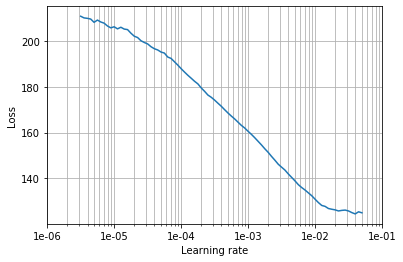

In [30]:
# if nothing shows up, re-run the previous code block
trainer.find_lr(beta=0.98, final_value=1e-1, num_itr=100)

In [31]:
trainer.set_lr(1e-3)

In [32]:
trainer.train(num_epoch=10)

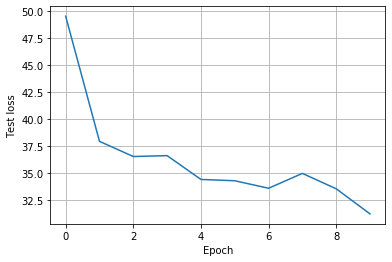

In [33]:
loss_cb.plot()
plt.show()

In [34]:
trainer.save_as_pth('cde_using_gmm_and_nn_pytorch.pth')

In [35]:
trainer.load_from_pth('cde_using_gmm_and_nn_pytorch.pth')

## Conditional mixing coefficients

In [36]:
model = trainer.learn.model

In [37]:
model.cpu().eval()
model_out = model(torch.from_numpy(x_valid).float())

means = model_out['means'].detach().numpy().reshape(-1, 4)
variances = model_out['variances'].detach().numpy()
mixing_coeffs = model_out['mixing_coeffs'].detach().numpy()

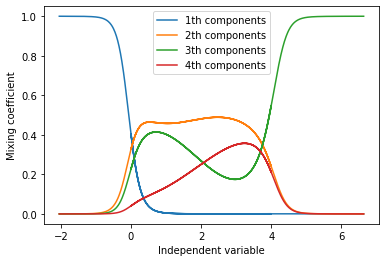

In [38]:
for i in range(num_components):
    plt.plot(x_valid.flatten(), mixing_coeffs[:,i], label=f'{i+1}th components')
plt.xlabel('Independent variable'); plt.ylabel('Mixing coefficient')
plt.legend()
plt.show()

## Conditional means and variances for Gaussian components

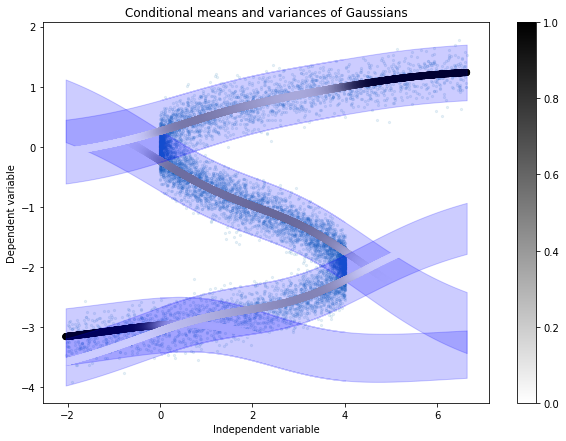

In [39]:
plt.figure(figsize=(10, 7))

# scatter the validation set
plt.scatter(x_valid, y_valid, s=5, alpha=0.1)

# for each gaussian component
for i in range(num_components):
    
    # remove the component(s) that are ignored during training
    if mixing_coeffs[:,i].max() > 0.01:
    
        # scatter means of the component, one for each value of the independent variable
        plt.scatter(
            x_valid.flatten(), 
            means[:,i],
            c=mixing_coeffs[:,i],
            cmap='binary',
            vmin=0,
            vmax=1
        )

        # shade standard deviations around the means, one for each value of the independent variable
        plt.fill_between(
            x_valid.flatten(), 
            means[:,i].flatten() - variances[:,i] ** 0.5, 
            means[:,i].flatten() + variances[:,i] ** 0.5,
            alpha=0.2,
            color='blue'
        )
    
plt.colorbar()

plt.xlabel('Independent variable'); plt.ylabel('Dependent variable'); 
plt.title('Conditional means and variances of Gaussians')

plt.show()

In the plot above, the color represents the value of a mixing coefficient; a darker color corresponds to a mixing coefficient close to 1, while a lighter color corresponds to a mixing coefficient close to 0.

## Conditional means and variances

In [40]:
conditional_means = np.sum(means * mixing_coeffs, axis=1)

In [41]:
partitions = np.linspace(x_valid.min(), x_valid.max(), 50)
mid_points = []
true_cmeans = []
true_cvars = []

for i in range(len(partitions) - 1):
    start, end = partitions[i], partitions[i+1]
    mid_point = (start + end) / 2
    idxs = np.where(np.logical_and(x_train >= start, x_train < end))
    ys = y_train[idxs]
    mid_points.append(mid_point)
    true_cmeans.append(np.mean(ys))
    true_cvars.append(np.std(ys))
    
true_cmeans, true_cvars = map(np.array, [true_cmeans, true_cvars])

In [42]:
conditional_variances = np.sum(
    mixing_coeffs * 
    (
        variances + (
            means - np.tile(np.sum(mixing_coeffs * means, axis=1).reshape(-1, 1), 4)
        ) ** 2
    ),
    axis=1
)

In [43]:
conditional_stds = conditional_variances ** (0.5)

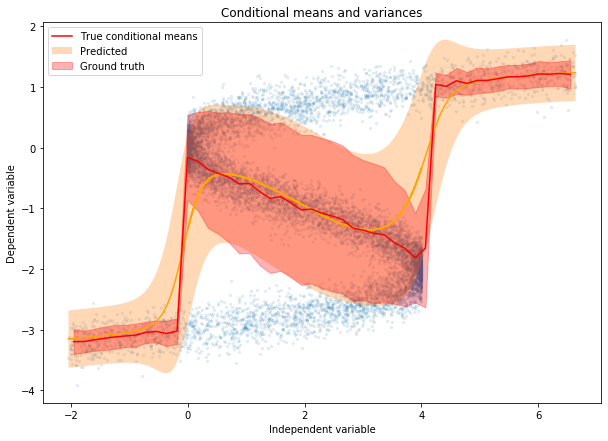

In [44]:
plt.figure(figsize=(10, 7))

plt.scatter(x_valid.flatten(), y_valid.flatten(), s=5, alpha=0.1)

plt.plot(x_valid.flatten(), conditional_means, color='orange')
plt.fill_between(
    x_valid.flatten(), 
    conditional_means - conditional_stds, 
    conditional_means + conditional_stds,
    alpha=0.3,
    label='Predicted'
)

plt.plot(mid_points, true_cmeans, label='True conditional means', color='red')
plt.fill_between(
    mid_points, 
    true_cmeans - true_cvars, 
    true_cmeans + true_cvars,
    alpha=0.3,
    color='red',
    label='Ground truth'
)

plt.xlabel('Independent variable'); plt.ylabel('Dependent variable'); 
plt.title('Conditional means and variances')

plt.legend()
plt.show()

Observations: sharp discontinuities were hard to model.

## Prediction

For each value of the independent variable, find the most probable branch of solution.

Check out the second answer of https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes to better understand the code below.

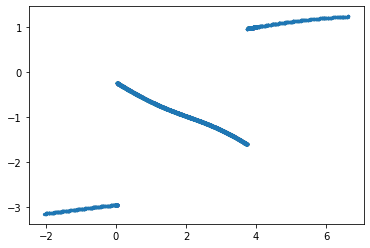

In [45]:
plt.scatter(
    x_valid.flatten(), 
    means[
        np.arange(len(means)), mixing_coeffs.argmax(axis=1)
    ],
    s=5
)
plt.show()